In [1]:
import json
import os
from tqdm import tqdm,trange
import numpy as np
import pandas as pd
import pickle
import torch
import pickle
import matplotlib.pyplot as plt
import random

### 1. 对CoNLL03的Confidence 进行画图。

In [35]:
# load td_df
td_df = pd.read_json('/home/qi/Projects/NER/ds_ner/out/plot_conll03_roberta_ns/dy_log/td_df.jsonl', lines=True)
# load aum_df
aum_df = pd.read_csv('/home/qi/Projects/NER/ds_ner/out/plot_conll03_roberta_ns/dy_log/aum_3/aum_values.csv')
aum_df = aum_df.rename(columns={'sample_id':'guid'})
all_df = pd.merge(td_df, aum_df, on='guid')

In [36]:
all_df.head(5)

,guid,index,threshold_closeness,confidence,variability,correctness,aum
0,0,0,0.096342,0.891992,0.079898,3,2.408976
1,1,1,0.000127,0.999873,0.000095,3,10.015764
2,2,2,0.008182,0.991750,0.005574,3,5.080401
3,3,3,0.000079,0.999921,0.000054,3,10.238366
4,4,4,0.000102,0.999898,0.000089,3,9.875795


In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# --------------------------------
dataframe = all_df
plot_dir = ''
hue_metric = 'aum'
title = 'CoNLL03'
model = 'RoBERTa-TopNeg'
show_hist = False
max_instances_to_plot = 20000 
# --------------------------------
# Keep all the positive guids and randomly sample negative guids
# load guids
dataset = 'conll03'
with open(f'/home/qi/Projects/NER/ds_ner/data/{dataset}/train-ds-samples.json', 'r') as f:
    ds_data = json.load(f)
entity_guids = []
non_entity_guids = []
for sample in ds_data:
    guids = sample['guids']
    spans_label = sample['spans_label']
    for i in range(len(spans_label)):
        if spans_label[i] != 0:
            entity_guids.append(guids[i])
        else:
            non_entity_guids.append(guids[i])
print("----- Loading entity guids and non_entity_guids sucessfully!")
print("Positive #:", len(entity_guids))
print("Negative #:", len(non_entity_guids))
neg_num = max_instances_to_plot - len(entity_guids)
negative_guids = random.sample(non_entity_guids, neg_num)
guids = entity_guids + negative_guids
# guids = entity_guids
# filter dataframe
dataframe = dataframe[dataframe['guid'].isin(guids)]

----- Loading entity guids and non_entity_guids sucessfully!
Positive #: 17776
Negative #: 1252102


In [117]:
aum_max = dataframe['aum'].max() 
aum_min = dataframe['aum'].min()
print("aum_max:", aum_max)
print("aum_min:", aum_min)

aum_max: 27.82946248352528
aum_min: -7.682450930277507


In [283]:
dataframe['aum_c'] = pd.cut(x=dataframe['aum'], bins=[-8, -5, -1, 0, 2, 5, 28], 
                     labels=[-8, -3, -1, 5, 20, 28])
dataframe['aum_c'] = dataframe['aum_c'].astype(int)

/tmp/ipykernel_2336964/1398083973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['aum_c'] = pd.cut(x=dataframe['aum'], bins=[-8, -5, -1, 0, 2, 5, 28],
/tmp/ipykernel_2336964/1398083973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['aum_c'] = dataframe['aum_c'].astype(int)


In [284]:
aum_max = dataframe['aum_c'].max() 
aum_min = dataframe['aum_c'].min()
print("aum_max:", aum_max)
print("aum_min:", aum_min)

aum_max: 28
aum_min: -8


In [285]:
main_metric = 'variability'
other_metric = 'confidence'
hue = 'aum_c'
num_hues = len(dataframe[hue].unique().tolist())
print("num_hues:", num_hues)

num_hues: 6


In [286]:
cmap = sns.color_palette('flare', as_cmap=True)
norm = plt.Normalize(vmin=aum_min, vmax=aum_max)  # 0 and 1 are the defaults, but you can adapt these to fit other uses
palette = {h: cmap(norm(h)) for h in dataframe['aum_c']}

In [261]:
# pal = sns.diverging_palette(0, 255, sep=1, n=num_hues*2, center='dark')
# # only select the even colors in pal list
# # pal = pal[:num_hues]
# # pal_list = pal[::2]
# # pal_list = pal_list.reverse()
# pal_list = pal[num_hues:]

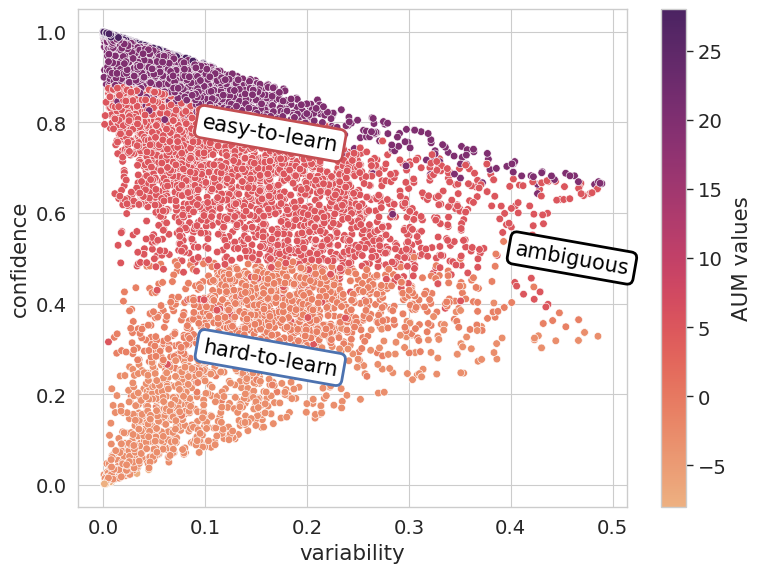

In [291]:
from matplotlib.cm import ScalarMappable
fig, ax0 = plt.subplots(1, 1, figsize=(8, 6))
plot = sns.scatterplot(x=main_metric, y=other_metric,
                       ax=ax0, data=dataframe, hue=hue,
                       palette=palette, s=30) # style=style 添加style的话，就会使用不用的 marker，但是就没法保证 legend 按照值的大小排列了
# remove legend
plot.get_legend().remove()
# Annotate Regions.
bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
func_annotate = lambda text, xyc, bbc : ax0.annotate(text, xy=xyc, xycoords="axes fraction", fontsize=15, 
                                                     color='black', va="center", ha="center", 
                                                     rotation=350, bbox=bb(bbc))
an1 = func_annotate("ambiguous", xyc=(0.9, 0.5), bbc='black')
an2 = func_annotate("easy-to-learn", xyc=(0.35, 0.75), bbc='r')
an3 = func_annotate("hard-to-learn", xyc=(0.35, 0.3), bbc='b')
# plot.legend(ncol=1, bbox_to_anchor=[0.175, 0.5], loc='right')
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=ax0, label='AUM values')
plot.set_xlabel('variability')
plot.set_ylabel('confidence')
fig.tight_layout()
plt.plot()
fig.savefig('./confident.pdf', dpi=300)
# print(f"Plot saved to {filename}")

### 2. CoNLL03的Case Study

In [1]:
import json
import os
from tqdm import tqdm,trange
import numpy as np
import pandas as pd
import pickle
import torch
import pickle
import matplotlib.pyplot as plt
import random

dataset = 'conll03'
# base_model = 'bert'
# base_model = 'bert_ns'
# base_model = 'roberta'
base_model = 'roberta_ns'


method = 'method1'
NEG_THES = 0.1
POS_THES = 0
print("Procssing dataset: ", dataset)
print("Base Model: ", base_model)
print("NEG_THES: ", NEG_THES)
print("POS_THES: ", POS_THES)


# ===== load noisy guids =====
# load incomplete and inaccurate guids
with open(f'/home/qi/Projects/NER/ds_ner/data/{dataset}/incomplete.pkl', 'rb') as f:
    incomplete_guids = pickle.load(f)
with open(f'/home/qi/Projects/NER/ds_ner/data/{dataset}/inaccurate.pkl', 'rb') as f:
    inaccurate_guids = pickle.load(f)
# 分离出ds数据中的entity span guids和非entity span guids
with open(f'/home/qi/Projects/NER/ds_ner/data/{dataset}/train-ds-samples.json', 'r') as f:
    ds_data = json.load(f)
entity_guids = []
non_entity_guids = []
for sample in ds_data:
    guids = sample['guids']
    spans_label = sample['spans_label']
    for i in range(len(spans_label)):
        if spans_label[i] != 0:
            entity_guids.append(guids[i])
        else:
            non_entity_guids.append(guids[i])
print("----- Loading entity guids and non_entity_guids sucessfully!")
print("Positive #:", len(entity_guids))
print("Negative #:", len(non_entity_guids))
# print(len(entity_guids), len(non_entity_guids))
print("----- Loading noisy guids sucessfully!")
print("False Negatives: ", len(incomplete_guids))
print("False Positives: ", len(inaccurate_guids))

for aum_num in range(3,4):
    print("----- AUM #:", aum_num, "-----")
    with open(f'/home/qi/Projects/NER/ds_ner/data/{dataset}/aum/fake_class_guids.pkl', 'rb') as f:
        aum_guids = pickle.load(f)
    # ===== Negative =====
    aum = pd.read_csv(f'/home/qi/Projects/NER/ds_ner/out/plot_{dataset}_{base_model}_td/dy_log/aum_{aum_num}/aum_values.csv')
    neg_aum = aum[aum['sample_id'].isin(non_entity_guids)]
    fake_aum = neg_aum[neg_aum['sample_id'].isin(aum_guids)]
    fake_aum = fake_aum.sort_values(by=['aum'], ascending=False)
    # fake_aum[:int(len(fake_aum)*0.5)]
    thres = fake_aum.iloc[int(len(fake_aum)*NEG_THES)]['aum']
    print("Neg Threshold: ", thres)

    # 真实的AUM
    aum = pd.read_csv(f'/home/qi/Projects/NER/ds_ner/out/plot_{dataset}_{base_model}/dy_log/aum_{aum_num}/aum_values.csv')
    hard_neg_aum = aum[aum['sample_id'].isin(non_entity_guids)]
    hard_neg_aum = hard_neg_aum.sort_values(by=['aum'], ascending=False)
    # iterative all the rows in hard_neg_aum
    rm_guids = []
    for i in range(len(hard_neg_aum)):
        row = hard_neg_aum.iloc[i]
        guid = row['sample_id']
        aum_value = row['aum']
        if aum_value < thres:
            rm_guids.append(guid)
    print("Removed total neg #:", len(rm_guids))
    inter_sec = list(set(rm_guids).intersection(incomplete_guids))
    print("Removed false neg #:", len(inter_sec))
    false_neg_guids = inter_sec

    # ===== Positive =====
    aum = pd.read_csv(f'/home/qi/Projects/NER/ds_ner/out/plot_{dataset}_{base_model}_td/dy_log/aum_{aum_num}/aum_values.csv')
    pos_aum = aum[aum['sample_id'].isin(entity_guids)]
    fake_aum = pos_aum[pos_aum['sample_id'].isin(aum_guids)]
    fake_aum = fake_aum.sort_values(by=['aum'], ascending=False)
    thre_aum = fake_aum.iloc[int(len(fake_aum)*POS_THES)]['aum']
    print("Pos Threshold: ", thre_aum)

    # 真实的AUM
    aum = pd.read_csv(f'/home/qi/Projects/NER/ds_ner/out/plot_{dataset}_{base_model}/dy_log/aum_{aum_num}/aum_values.csv')
    hard_pos_aum = aum[aum['sample_id'].isin(entity_guids)]
    hard_pos_aum = hard_pos_aum.sort_values(by=['aum'], ascending=False)
    # iterative all the rows in hard_neg_aum
    rm_guids = []
    for i in range(len(hard_pos_aum)):
        row = hard_pos_aum.iloc[i]
        guid = row['sample_id']
        aum_value = row['aum']
        if aum_value < thre_aum:
            rm_guids.append(guid)
    print("Removed total pos #:", len(rm_guids))
    inter_sec = list(set(rm_guids).intersection(inaccurate_guids))
    false_pos_guids = inter_sec
    print("Removed false pos #:", len(inter_sec))

Procssing dataset:  conll03
Base Model:  roberta_ns
NEG_THES:  0.1
POS_THES:  0
----- Loading entity guids and non_entity_guids sucessfully!
Positive #: 17776
Negative #: 1252102
----- Loading noisy guids sucessfully!
False Negatives:  8146
False Positives:  3128
----- AUM #: 3 -----
Neg Threshold:  3.1618683338165283
Removed total neg #: 18748
Removed false neg #: 6951
Pos Threshold:  0.8524222572644552
Removed total pos #: 3203
Removed false pos #: 2197


In [45]:
with open(f'/home/qi/Projects/NER/ds_ner/data/{dataset}/train-ds-samples.json', 'r') as f:
    ds_data = json.load(f)

case_samples = []
for sample in tqdm(ds_data):
    guids = sample['guids']
    spans = sample['spans']
    spans_label = sample['spans_label']
    # for error
    error_guids = []
    error_spans = []
    error_spans_label = []
    for i in range(len(guids)):
        if guids[i] in false_neg_guids or guids[i] in false_pos_guids:
            error_guids.append(guids[i])
            error_spans.append(spans[i])
            error_spans_label.append(spans_label[i])
    if len(error_guids) > 0:
        case_samples.append({'tokens': sample['tokens'],'guids': error_guids, 'spans': error_spans, 'spans_label': error_spans_label})

100%|██████████| 14041/14041 [01:15<00:00, 186.45it/s]


In [50]:
both_samples = []
for sample in case_samples:
    if len(sample['tokens']) < 17 and len(sample['tokens']) > 10:
    # if 1 in sample['spans_label'] or 0 in sample['spans_label']:
        both_samples.append(sample)

In [51]:
len(both_samples)

654

In [55]:
for i in range(40,60):
    print("----- Sample #:", i, "-----")
    sample = both_samples[i]
    print("tokens:", sample['tokens'])
    print("spans:", sample['spans'])
    print("spans_label:", sample['spans_label'])
    print("-----")

----- Sample #: 40 -----
tokens: ['In', 'Bistrita', ':', 'Gloria', 'Bistrita', '(', 'Romania', ')', '0', 'Valletta', '(', 'Malta', ')', '0']
spans: [[1, 1, 1]]
spans_label: [0]
-----
----- Sample #: 41 -----
tokens: ['In', 'Chorzow', ':', 'Ruch', 'Chorzow', '(', 'Poland', ')', '0', 'Llansantffraid', '(', 'Wales', ')', '0']
spans: [[1, 1, 1], [9, 9, 1]]
spans_label: [0, 0]
-----
----- Sample #: 42 -----
tokens: ['Scorers', ':', 'Arkadiusz', 'Bak', '(', '0st', 'and', '00th', ')', ',', 'Arwel', 'Jones', '(', '00th', ',']
spans: [[10, 11, 2], [11, 11, 1]]
spans_label: [0, 3]
-----
----- Sample #: 43 -----
tokens: ['In', 'Larnaca', ':', 'AEK', 'Larnaca', '(', 'Cyprus', ')', '0', 'Kotaik', 'Abovyan', '(', 'Armenia', ')']
spans: [[9, 10, 2]]
spans_label: [0]
-----
----- Sample #: 44 -----
tokens: ['Milenko', 'Kovasevic', '(', '00th', ',', 'penalty', ')', ',', 'Goran', 'Koprinovic', '(', '00nd', ')', ',']
spans: [[0, 0, 1], [0, 1, 2], [8, 8, 1], [8, 9, 2]]
spans_label: [3, 0, 3, 0]
-----
-----

In [56]:
sample_id = 58
print(' '.join(both_samples[sample_id]['tokens']))

Orioles ' bench coach Andy Etchebarren will manage the club in Johnson 's absence .


In [17]:
with open(f'/home/qi/Projects/NER/ds_ner/data/{dataset}/train-gs-samples.json', 'r') as f:
    gs_data = json.load(f)
with open(f'/home/qi/Projects/NER/ds_ner/data/{dataset}/train-ds-samples.json', 'r') as f:
    ds_data = json.load(f)

In [57]:
for gs_sample in gs_data:
    if gs_sample['tokens'] == both_samples[sample_id]['tokens']:
        gs_case = gs_sample
print("Gold Standard:")
print(gs_case['tokens'])
for i in range(len(gs_case['spans'])):
    if gs_case['spans_label'][i] != 0:
        print(gs_case['spans'][i], gs_case['spans_label'][i])

Gold Standard:
['Orioles', "'", 'bench', 'coach', 'Andy', 'Etchebarren', 'will', 'manage', 'the', 'club', 'in', 'Johnson', "'s", 'absence', '.']
[0, 0, 1] 1
[4, 5, 2] 3
[11, 11, 1] 3


In [58]:
for ds_sample in ds_data:
    if ds_sample['tokens'] == both_samples[sample_id]['tokens']:
        ds_case = ds_sample
print("Distant Supervision:")
print(ds_case['tokens'])
for i in range(len(ds_case['spans'])):
    if ds_case['spans_label'][i] != 0:
        print(ds_case['spans'][i], ds_case['spans_label'][i])

Distant Supervision:
['Orioles', "'", 'bench', 'coach', 'Andy', 'Etchebarren', 'will', 'manage', 'the', 'club', 'in', 'Johnson', "'s", 'absence', '.']
[4, 4, 1] 3
[11, 11, 1] 3


In [35]:
print((' ').join(ds_case['tokens']))

U.S. Treasury balances at Federal Reserve based on Treasury Department 's latest budget statement .


### 3. Threshold Sample Effectiveness

In [5]:
import os
import argparse
import csv
import ast
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
import json
import os
from tqdm import tqdm,trange
import numpy as np
import pandas as pd
import pickle
import torch
import pickle
import matplotlib.pyplot as plt
import random

dataset = 'conll03'
# base_model = 'bert'
# base_model = 'bert_ns'
# base_model = 'roberta'
base_model = 'roberta_ns'


method = 'method1'
NEG_THES = 0.1
POS_THES = 0
print("Procssing dataset: ", dataset)
print("Base Model: ", base_model)
print("NEG_THES: ", NEG_THES)
print("POS_THES: ", POS_THES)


# ===== load noisy guids =====
# load incomplete and inaccurate guids
with open(f'/home/qi/Projects/NER/ds_ner/data/{dataset}/incomplete.pkl', 'rb') as f:
    incomplete_guids = pickle.load(f)
with open(f'/home/qi/Projects/NER/ds_ner/data/{dataset}/inaccurate.pkl', 'rb') as f:
    inaccurate_guids = pickle.load(f)
# 分离出ds数据中的entity span guids和非entity span guids
with open(f'/home/qi/Projects/NER/ds_ner/data/{dataset}/train-ds-samples.json', 'r') as f:
    ds_data = json.load(f)
entity_guids = []
non_entity_guids = []
for sample in ds_data:
    guids = sample['guids']
    spans_label = sample['spans_label']
    for i in range(len(spans_label)):
        if spans_label[i] != 0:
            entity_guids.append(guids[i])
        else:
            non_entity_guids.append(guids[i])
print("----- Loading entity guids and non_entity_guids sucessfully!")
print("Positive #:", len(entity_guids))
print("Negative #:", len(non_entity_guids))
# print(len(entity_guids), len(non_entity_guids))
print("----- Loading noisy guids sucessfully!")
print("False Negatives: ", len(incomplete_guids))
print("False Positives: ", len(inaccurate_guids))

for aum_num in range(3,4):
    print("----- AUM #:", aum_num, "-----")
    with open(f'/home/qi/Projects/NER/ds_ner/data/{dataset}/aum/fake_class_guids.pkl', 'rb') as f:
        aum_guids = pickle.load(f)
    # ===== Negative =====
    aum = pd.read_csv(f'/home/qi/Projects/NER/ds_ner/out/plot_{dataset}_{base_model}_td/dy_log/aum_{aum_num}/aum_values.csv')
    neg_aum = aum[aum['sample_id'].isin(non_entity_guids)]
    fake_aum = neg_aum[neg_aum['sample_id'].isin(aum_guids)]
    fake_aum = fake_aum.sort_values(by=['aum'], ascending=False)
    # fake_aum[:int(len(fake_aum)*0.5)]
    thres = fake_aum.iloc[int(len(fake_aum)*NEG_THES)]['aum']
    print("Neg Threshold: ", thres)
    neg_fake_aum = fake_aum
    print("Neg Fake #:", len(neg_fake_aum))

    # 真实的AUM
    aum = pd.read_csv(f'/home/qi/Projects/NER/ds_ner/out/plot_{dataset}_{base_model}/dy_log/aum_{aum_num}/aum_values.csv')
    neg_aum = aum[aum['sample_id'].isin(non_entity_guids)]
    neg_aum = neg_aum.sort_values(by=['aum'], ascending=False)
    print("Neg Real #:", len(neg_aum))

    # ===== Positive =====
    aum = pd.read_csv(f'/home/qi/Projects/NER/ds_ner/out/plot_{dataset}_{base_model}_td/dy_log/aum_{aum_num}/aum_values.csv')
    pos_aum = aum[aum['sample_id'].isin(entity_guids)]
    fake_aum = pos_aum[pos_aum['sample_id'].isin(aum_guids)]
    fake_aum = fake_aum.sort_values(by=['aum'], ascending=False)
    thre_aum = fake_aum.iloc[int(len(fake_aum)*POS_THES)]['aum']
    print("Pos Threshold: ", thre_aum)
    pos_fake_aum = fake_aum
    print("Pos Fake #:", len(pos_fake_aum))

    # 真实的AUM
    aum = pd.read_csv(f'/home/qi/Projects/NER/ds_ner/out/plot_{dataset}_{base_model}/dy_log/aum_{aum_num}/aum_values.csv')
    pos_aum = aum[aum['sample_id'].isin(entity_guids)]
    pos_aum = pos_aum.sort_values(by=['aum'], ascending=False)
    print("Pos Real #:", len(pos_aum))
    

Procssing dataset:  conll03
Base Model:  roberta_ns
NEG_THES:  0.1
POS_THES:  0
----- Loading entity guids and non_entity_guids sucessfully!
Positive #: 17776
Negative #: 1252102
----- Loading noisy guids sucessfully!
False Negatives:  8146
False Positives:  3128
----- AUM #: 3 -----
Neg Threshold:  3.1618683338165283
Neg Fake #: 4444
Neg Real #: 1252102
Pos Threshold:  0.8524222572644552
Pos Fake #: 4442
Pos Real #: 17776


In [2]:
# for negative
neg_th_aum = []
neg_or_aum = []
for row in neg_fake_aum.iterrows():
    # guid = row['sample_id']
    aum = row[1]['aum']
    neg_th_aum.append(aum)
for row in neg_aum.iterrows():
    # guid = row['sample_id']
    aum = row[1]['aum']
    neg_or_aum.append(aum)

In [3]:
len(neg_th_aum), len(neg_or_aum)

(4444, 1252102)

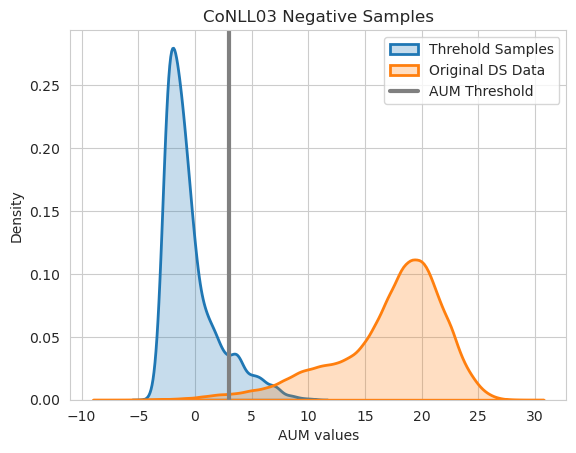

In [15]:
sns.set_style('whitegrid')
plot = sns.kdeplot(np.array(neg_th_aum), bw_adjust=1, label='Threhold Samples', fill=True, linewidth=2)
plot = sns.kdeplot(np.array(neg_or_aum), bw_adjust=1, label='Original DS Data', fill=True, linewidth=2)
plt.axvline(x=3, color='gray', linestyle='-', linewidth=3, label="AUM Threshold")
plt.xlabel("AUM values")
plt.title("CoNLL03 Negative Samples")
plot.legend()
plt.savefig('../plot/conll03_roberta_ns_aum_3_neg.pdf', dpi=300)

In [13]:
# for negative
pos_th_aums = []
pos_or_aums = []
for row in pos_fake_aum.iterrows():
    # guid = row['sample_id']
    aum = row[1]['aum']
    pos_th_aums.append(aum)
for row in pos_aum.iterrows():
    # guid = row['sample_id']
    aum = row[1]['aum']
    pos_or_aums.append(aum)

In [14]:
len(pos_th_aums), len(pos_or_aums)

(4442, 17776)

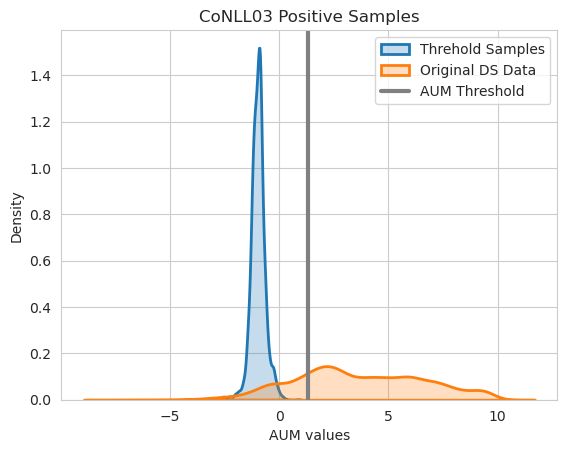

In [16]:
sns.set_style('whitegrid')
plot = sns.kdeplot(np.array(pos_th_aums), bw_adjust=1, label='Threhold Samples', fill=True, linewidth=2)
plot = sns.kdeplot(np.array(pos_or_aums), bw_adjust=1, label='Original DS Data', fill=True, linewidth=2)
plt.axvline(x=1.3, color='gray', linestyle='-', linewidth=3, label="AUM Threshold")
plt.title("CoNLL03 Positive Samples")
plt.xlabel("AUM values")
plot.legend()
plt.savefig('../plot/conll03_roberta_ns_aum_3_pos.pdf', dpi=300)

### 4. Ablation Study for Fixed threshold

In [2]:
import os
import argparse
import csv
import ast
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# When RM NEG is fixed
Precision = [0.878566667, 0.811586667, 0.805726667, 0.802186667, 0.79392]
Precision = [ elem * 100 for elem in Precision ]
Precision.reverse()
Recall = [0.825603333,0.839886667,0.831386667,0.834043333,0.83481]
Recall = [ elem * 100 for elem in Recall ]
Recall.reverse()
F1 = [0.851253333,0.825493333,0.81832,0.817716667,0.81378]
F1 = [ elem * 100 for elem in F1 ]
F1.reverse()
RM_POS_NUM = [ 3234, 2098, 1825, 1678,1543 ]
RM_POS_NUM.reverse()
X_axis = ["80%", "85%", "90%", "95%", "100%"]

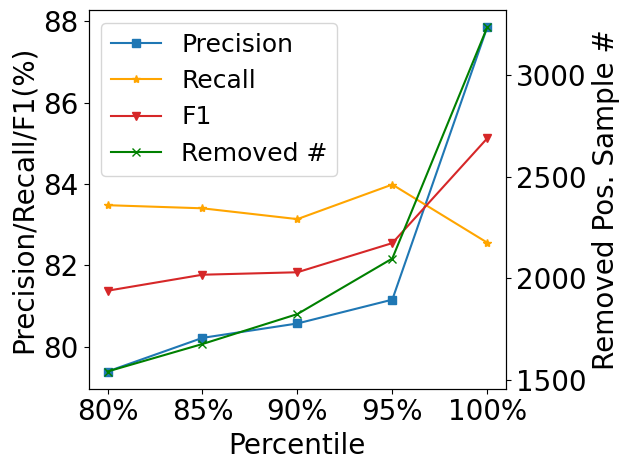

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Create some mock data
# t = [0,1,2,3,4]
# data1 = np.exp(t)
# data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Percentile', fontsize=20)
ax1.set_ylabel('Precision/Recall/F1(%)', fontsize=20)
line1 = ax1.plot(X_axis, Precision, color='tab:blue', label='Precision', marker='s')
line2 = ax1.plot(X_axis, Recall, color='orange', label='Recall', marker='*')
line3 = ax1.plot(X_axis, F1, color='tab:red', label='F1', marker='v')
ax1.tick_params(axis='y', labelsize=20)
# ax1.legend(loc='upper left')
ax1.tick_params(axis='x', labelsize=20)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'green'
ax2.set_ylabel('Removed Pos. Sample #', fontsize=20)  # we already handled the x-label with ax1
line4 = ax2.plot(X_axis, RM_POS_NUM, color=color, label='Removed #', marker='x')
ax2.tick_params(axis='y',labelsize=20)
# ax2.legend(loc='lower right')

lns = line1+line2+line3+line4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left', fontsize=18)
# ax1.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# set up the dpi
plt.savefig('../images/conll03_roberta_ns_diff_percentile_fixed_neg.pdf', dpi=300)
plt.show()

In [7]:
# When RM POS is fixed
Precision = [0.603146667,0.814403333,0.878566667,0.87812,0.900496667]
Precision = [ elem * 100 for elem in Precision ]
Precision.reverse()
Recall = [0.874056667,0.847026667,0.825603333,0.808486667,0.751593333]
Recall = [ elem * 100 for elem in Recall ]
Recall.reverse()
F1 = [0.713623333,0.829953333,0.851253333,0.841816667,0.819266667]
F1 = [ elem * 100 for elem in F1 ]
F1.reverse()
RM_NEG_NUM = [ 65638,25512,15311,8049,5301]
RM_NEG_NUM.reverse()
X_axis = ["80%", "85%", "90%", "95%", "100%"]

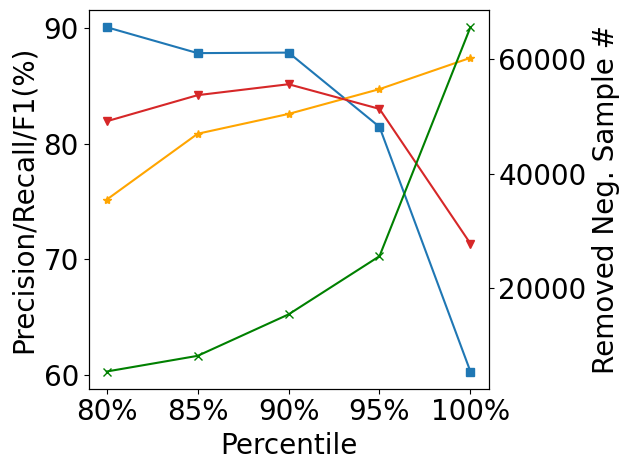

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Create some mock data
# t = [0,1,2,3,4]
# data1 = np.exp(t)
# data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Percentile', fontsize=20)
ax1.set_ylabel('Precision/Recall/F1(%)', fontsize=20)
ax1.plot(X_axis, Precision, color='tab:blue', label='Precision', marker='s')
ax1.plot(X_axis, Recall, color='orange', label='Recall', marker='*')
ax1.plot(X_axis, F1, color='tab:red', label='F1', marker='v')
ax1.tick_params(axis='y', labelsize=20)
# ax1.legend(loc='upper left')
ax1.tick_params(axis='x', labelsize=20)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'green'
ax2.set_ylabel('Removed Neg. Sample #', fontsize=20)  # we already handled the x-label with ax1
ax2.plot(X_axis, RM_NEG_NUM, color=color, label='Removed #', marker='x')
ax2.tick_params(axis='y', labelsize=20)
# ax2.legend(loc='lower right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# set up the dpi
plt.savefig('../images/conll03_roberta_ns_diff_percentile_fixed_pos.pdf', dpi=300)
plt.show()